In [0]:
# Importing modules and libraries
%matplotlib inline
import os
import pandas as pd
import numpy as np
from fastai.vision import *
import librosa
import librosa.display
import matplotlib

In [0]:
# Mounting Google drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Function to create spectogram of each image
def create_spectogram(filename):
    y, sr = librosa.load('/content/drive/My Drive/heartbeats/set_b/'+ filename, duration=3)
    ps = librosa.feature.melspectrogram(y=y, sr=sr,power=2)
    S_dB = librosa.power_to_db(ps, ref=np.max)
    librosa.display.specshow(S_dB, y_axis='mel', x_axis='time')
    plt.savefig(os.path.join('/content/drive/My Drive/heartbeats/spec2/'+ filename[:-4]+'.jpg')) # Saving them in a directory

In [0]:
# Labels data
df=pd.read_csv('/content/drive/My Drive/heartbeats/set_b.csv')
df.head()

,fname,label
0,extrastole__127_1306764300147_C2.wav,extrastole
1,extrastole__128_1306344005749_A.wav,extrastole
2,extrastole__130_1306347376079_D.wav,extrastole
3,extrastole__134_1306428161797_C1.wav,extrastole
4,extrastole__138_1306762146980_B.wav,extrastole


In [0]:
# Applying create_spectogram function to all the audio files
for i in df.fname:
    create_spectogram(i)

In [0]:
# Preparing data
path = '/content/drive/My Drive/heartbeats/spec2'
np.random.seed(1)
data = (ImageList.from_csv(path, 'image_rep.csv', cols='fname')
        # Location of image file names
        .split_by_rand_pct(0.3)
        # Splitting 30% of data to valid data
        .label_from_df(cols='label')
        # Assigning labels to each image from a csv file
        .transform( size=512, resize_method=ResizeMethod.SQUISH)
        # Resizing every image to 512*512
        .databunch(bs=4)                        
        # Choosing a batch size of 4
        .normalize(imagenet_stats))
        # Normalizing each channel of an image with some default stats

In [0]:
data.classes # Labels in the data

['extrastole', 'murmur', 'normal']

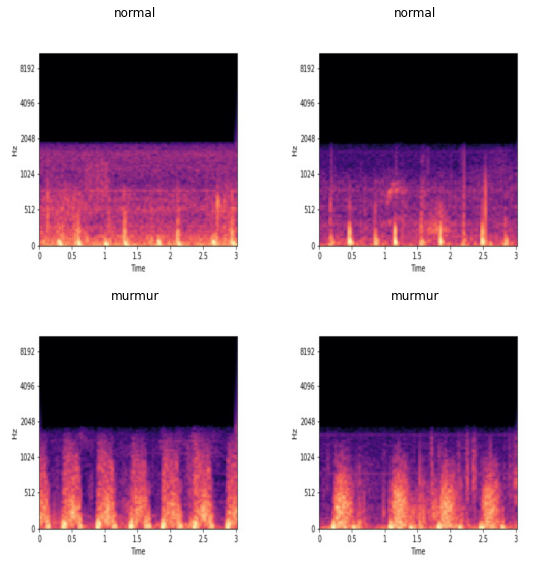

In [0]:
data.show_batch()

In [0]:
# Resnet34 architecture
arch = models.resnet34

In [0]:
# Model
from fastai.metrics import error_rate
learn = cnn_learner(data, arch, metrics=error_rate)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 3.31E-03


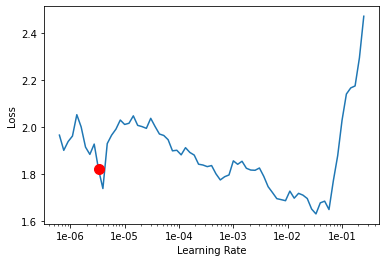

In [0]:
learn.recorder.plot(suggestion=True) 

In [0]:
# Choosing a learning rate value from the above recommendation
lr = 1E-06  

# Choosing pretrained weights except in the last group of layers
learn.freeze()  

In [0]:
# Fitting the model using cyclical rate of learning rate

learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.126282,0.696434,0.333333,00:06
1,1.189842,0.764091,0.397849,00:06
2,1.120037,0.750461,0.354839,00:06
3,1.197918,0.779972,0.397849,00:06
4,1.293952,0.703625,0.301075,00:06


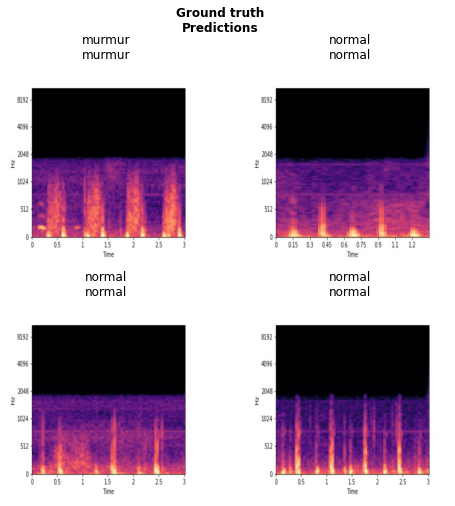

In [0]:
# Results on one batch of the validated set

learn.show_results()

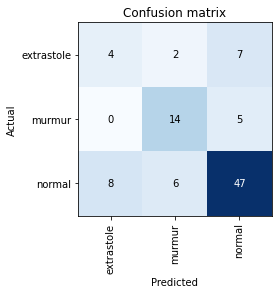

In [0]:
# Confusion matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()